In [1]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from pandarallel import pandarallel
from sklearn.model_selection import cross_val_score
import sys
sys.path.insert(1, '/home/andrew/projects/congress_twitter/congress_twitter/scripts')
import text_processing
import spacy
import plotnine as p9
from plotnine.data import mpg
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

In [2]:
from importlib import reload
reload(text_processing)

<module 'text_processing' from '/home/andrew/projects/congress_twitter/congress_twitter/scripts/text_processing.py'>

In [3]:
 p9.options.figure_size = (12, 6.8)

# Overview

Presented here are exploratory analyses of tweets by U.S. Congress members during the years 2020 and part of 2021, with an emphasis on identifying textual or other features that differentiate Democratic and Republican politicians.

# Input data

## Twitter handles

Twitter handles were scraped from a pre-prepared HTML table, with relevant annotations of chamber and party. 

In [4]:
twitter_handles = pd.read_csv("../data/congress_twitter_handles_cleaned.csv")

twitter_handles.head()

,Unnamed: 0,state,chamber,name,Website,party,username,Twitter Links,Instagram,Instagram Links,Facebook,Facebook links
0,0,Alabama,Senator,"Shelby, Richard",https://www.shelby.senate.gov/public/,R,SenShelby,https://twitter.com/SenShelby?ref_src=twsrc%5E...,@senatorshelby,https://www.instagram.com/senatorshelby/,x,https://www.facebook.com/RichardShelby
1,1,Alabama,Senator,"Tuberville, Tommy",https://www.tuberville.senate.gov/,R,Ttuberville,https://twitter.com/ttuberville?lang=en,@sentuberville,https://www.instagram.com/sentuberville/,x,https://www.facebook.com/TommyForSenate/
2,2,Alabama 1st District,Representative,"Carl, Jerry",https://carl.house.gov/,R,RepJerryCarl,https://twitter.com/RepJerryCarl,@repjerrycarl,https://www.instagram.com/repjerrycarl/,x,https://www.facebook.com/RepJerryCarl/
3,3,Alabama 2nd District,Representative,"Moore, Barry",https://barrymoore.house.gov/,R,RepBarryMoore,https://twitter.com/RepBarryMoore?ref_src=twsr...,@barrymooreforcongress,https://www.instagram.com/barrymooreforcongress/,x,https://www.facebook.com/RepBarryMoore/
4,4,Alabama 3rd District,Representative,"Rogers, Mike",http://mikerogers.house.gov/,R,RepMikeRogers,https://twitter.com/repmikerogers?lang=en,@repmikerogersal,https://www.instagram.com/repmikerogersal/?hl=en,x,https://www.facebook.com/CongressmanMikeDRogers/


## All tweets

All tweets from handles believed to belong to members of congress were then scraped.  It appeared as though retweets from other users were also coming through, so an additional filter was added here to require that tweets in the final dataframe were authored by users in the handles dataframe.

In [5]:
all_tweets = pd.read_csv("../data/all_tweets_full.csv")

all_tweets['tweet_content_no_url'] = \
    all_tweets['tweet_content'].apply(lambda x: re.sub(r"\S*https?:\S*", "", x))

all_tweets['tweet_content_cleaned'] = \
    all_tweets['tweet_content_no_url'].apply(lambda x: x.replace("&amp;", "").replace("\n", " "))

In [6]:
#all_tweets = all_tweets[["username", "date", "tweet_content", "party", "chamber", "state", "name"]]
all_tweets.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,username,date,tweet_content,party,state,chamber,name,...,PRON,SYM,SCONJ,INTJ,neg,neu,pos,compound,tweet_content_no_url,tweet_content_cleaned
0,0,0,0.0,RepTerriSewell,2021-07-06 19:45:12+00:00,189 people killed. 540 shootings. In a single ...,D,Alabama 7th District,Representative,"Sewell, Terri A.",...,0.0,0.0,0.0,0.0,0.364,0.636,0.000,-0.9661,189 people killed. 540 shootings. In a single ...,189 people killed. 540 shootings. In a single ...
1,1,1,1.0,RepTerriSewell,2021-07-06 15:24:27+00:00,"🚨ALABAMA FAMILIES🚨\n\nIn just 9 days, hard-wor...",D,Alabama 7th District,Representative,"Sewell, Terri A.",...,1.0,1.0,0.0,0.0,0.000,0.884,0.116,0.6988,"🚨ALABAMA FAMILIES🚨\n\nIn just 9 days, hard-wor...","🚨ALABAMA FAMILIES🚨 In just 9 days, hard-worki..."
2,2,2,2.0,RepTerriSewell,2021-07-04 15:33:57+00:00,Happy #July4th Alabama!\n\nAs we celebrate our...,D,Alabama 7th District,Representative,"Sewell, Terri A.",...,7.0,0.0,0.0,0.0,0.079,0.517,0.404,0.9686,Happy #July4th Alabama!\n\nAs we celebrate our...,Happy #July4th Alabama! As we celebrate our n...
3,3,3,3.0,RepTerriSewell,2021-07-03 00:02:45+00:00,On the 57th anniversary of the #CivilRightsAct...,D,Alabama 7th District,Representative,"Sewell, Terri A.",...,4.0,1.0,1.0,0.0,0.083,0.711,0.205,0.7600,On the 57th anniversary of the #CivilRightsAct...,On the 57th anniversary of the #CivilRightsAct...
4,4,4,4.0,RepTerriSewell,2021-07-02 16:18:27+00:00,Wonderful news from today’s jobs report!\n\n✅ ...,D,Alabama 7th District,Representative,"Sewell, Terri A.",...,1.0,0.0,1.0,0.0,0.000,0.902,0.098,0.7412,Wonderful news from today’s jobs report!\n\n✅ ...,Wonderful news from today’s jobs report! ✅ Wa...


In [7]:
pos_cols = ['PRON', 'VERB', 'ADV', 'PROPN', 
            'DET', 'NOUN', 'CCONJ', 'AUX', 
            'ADP', 'PUNCT', 'ADJ', 'X', 'PART',
            'SCONJ', 'SPACE', 'NUM', 'INTJ', 'SYM']

sentiment_cols = ["neg", "neu", "pos", "compound"]




# Exploratory analyses

## Word clouds

Word clouds generated from all tweets by Democratic and, separately, Republican members of congress. Size of words are proportional to their frequency of use in tweets.

In [8]:
dem_all_words = ' '.join([i for i in all_tweets["tweet_content_cleaned"][all_tweets["party"] == "D"]])
rep_all_words = ' '.join([i for i in all_tweets["tweet_content_cleaned"][all_tweets["party"] == "R"]])

In [11]:
len(dem_all_words)

62928888

In [12]:
len(rep_all_words)

36589316

In [13]:
wordcloud = WordCloud(
    width = 800, 
    height = 500, 
    random_state = 42, 
    max_font_size = 110).generate(dem_all_words)

### Democrat tweets word cloud

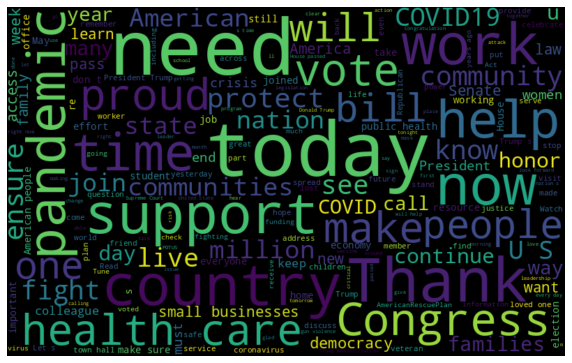

In [14]:
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [15]:
wordcloud = WordCloud(
    width = 800, 
    height = 500, 
    random_state = 42, 
    max_font_size = 110).generate(rep_all_words)

### Republican tweets word cloud

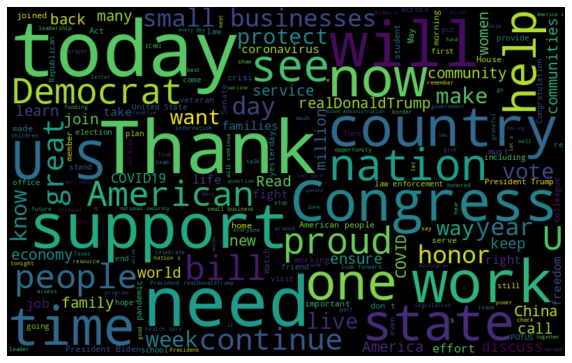

In [16]:
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Tweet Frequencies

In [34]:
tweet_counts = \
    all_tweets.groupby(["username", "party", "chamber", "state"], as_index = False)\
        .size()\
        .sort_values("size",ascending=False)

In [35]:
tweet_counts

,username,party,chamber,state,size
72,JohnCornyn,R,Senator,Texas,4680
7,BillHagertyTN,R,Senator,Tennessee,4602
8,BillPascrell,D,Representative,New Jersey 9th District,4542
490,mtgreenee,R,Representative,Georgia 14th District,4075
418,SenTedCruz,R,Senator,Texas,3754
...,...,...,...,...,...
101,MikeKellyforPA,R,Representative,Pennsylvania 16th District,23
306,RepMoolenaar,R,Representative,Michigan 4th District,18
413,SenSasse,R,Senator,Nebraska,9
41,FallonForTexas,R,Representative,Texas 4th District,5


### Tweets by party

Plotting the density of total tweets in the given time period by individual members of congress seems to show that Democrats tweet on average more frequently than Republicans, in both chambers.

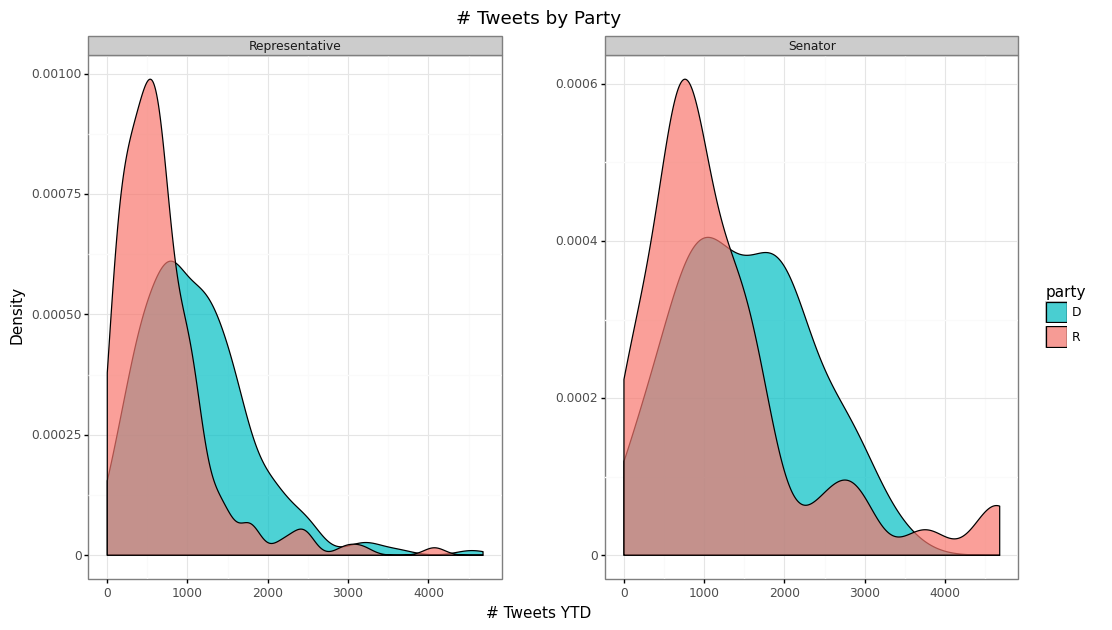

<ggplot: (8732459202666)>

In [36]:
p9.ggplot(
    tweet_counts,
    p9.aes(x = "size",
           fill = "party")) + \
    p9.geom_density(alpha = 0.7) + \
    p9.theme_bw() + \
    p9.ylab("Density") + \
    p9.xlab("# Tweets YTD") + \
    p9.ggtitle("# Tweets by Party") + \
    p9.facet_wrap("~ chamber", scales = "free_y") + \
    p9.theme(subplots_adjust={"wspace": 0.25}) + \
    p9.scale_fill_manual(values = {"D": "#00BFC4", "R": "#F8766D"})

### Tweets by chamber

Switching the grouping to show party in different facets and chamber by shading suggests that senators tweet more often on average than representatives, regardless of party.

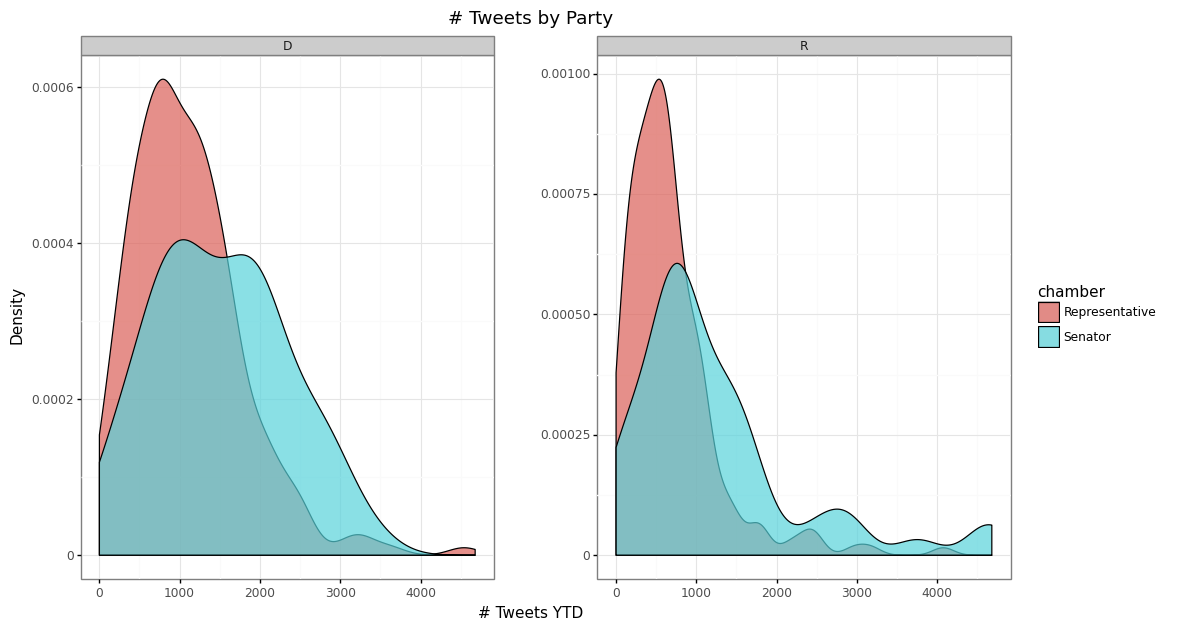

<ggplot: (8732254618718)>

In [37]:
p9.ggplot(
    tweet_counts,
    p9.aes(x = "size",
           fill = "chamber")) + \
    p9.geom_density(alpha = 0.7) + \
    p9.theme_bw() + \
    p9.ylab("Density") + \
    p9.xlab("# Tweets YTD") + \
    p9.ggtitle("# Tweets by Party") + \
    p9.facet_wrap("~ party", scales = "free_y") + \
    p9.theme(subplots_adjust = {"wspace": 0.25})

In [38]:
tweet_counts_person = all_tweets\
    .groupby(["name", "chamber", "state", "party"], as_index = False)\
    .size()\
    .sort_values(by = "size", ascending = False)

tweet_counts_person

,name,chamber,state,party,size
92,"Cornyn, John",Senator,Texas,R,4680
187,"Hagerty, Bill",Senator,Tennessee,R,4602
352,"Pascrell Jr., Bill",Representative,New Jersey 9th District,D,4542
179,"Greene, Marjorie Taylor",Representative,Georgia 14th District,R,4075
105,"Cruz, Ted",Senator,Texas,R,3754
...,...,...,...,...,...
236,"Kelly, Mike",Representative,Pennsylvania 16th District,R,23
313,"Moolenaar, John",Representative,Michigan 4th District,R,18
400,"Sasse, Ben",Senator,Nebraska,R,9
135,"Fallon, Pat",Representative,Texas 4th District,R,5


### Tweet counts by person

Need to replace or eliminate this -- can't see what's going on currently. 

In [39]:
top50_tweeters = tweet_counts_person.iloc[0:50,:].reset_index()

top50_tweeters.head()


,index,name,chamber,state,party,size
0,92,"Cornyn, John",Senator,Texas,R,4680
1,187,"Hagerty, Bill",Senator,Tennessee,R,4602
2,352,"Pascrell Jr., Bill",Representative,New Jersey 9th District,D,4542
3,179,"Greene, Marjorie Taylor",Representative,Georgia 14th District,R,4075
4,105,"Cruz, Ted",Senator,Texas,R,3754


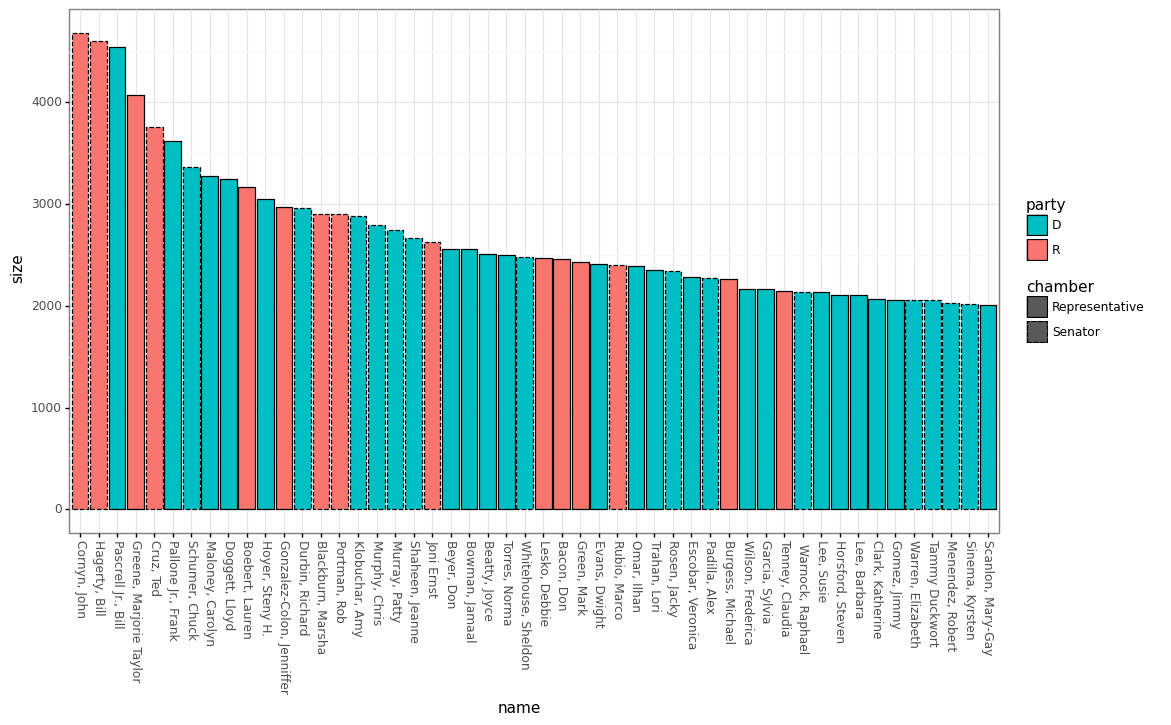

<ggplot: (8732254379990)>

In [40]:
p9.ggplot(
    top50_tweeters,
    p9.aes(x = "name", y = "size", fill = "party", linetype = "chamber")) + \
    p9.geom_col(color = "black") + \
    p9.theme_bw() + \
    p9.theme(axis_text_x = p9.element_text(angle = -90)) + \
    p9.scale_x_discrete(limits = top50_tweeters.name.to_list()) + \
    p9.scale_fill_manual(values = {"D": "#00BFC4", "R": "#F8766D"})

## Sentiment 

### Sentiment by party and chamber

/home/andrew/projects/congress_twitter/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 95'. Pick better value with 'binwidth'.


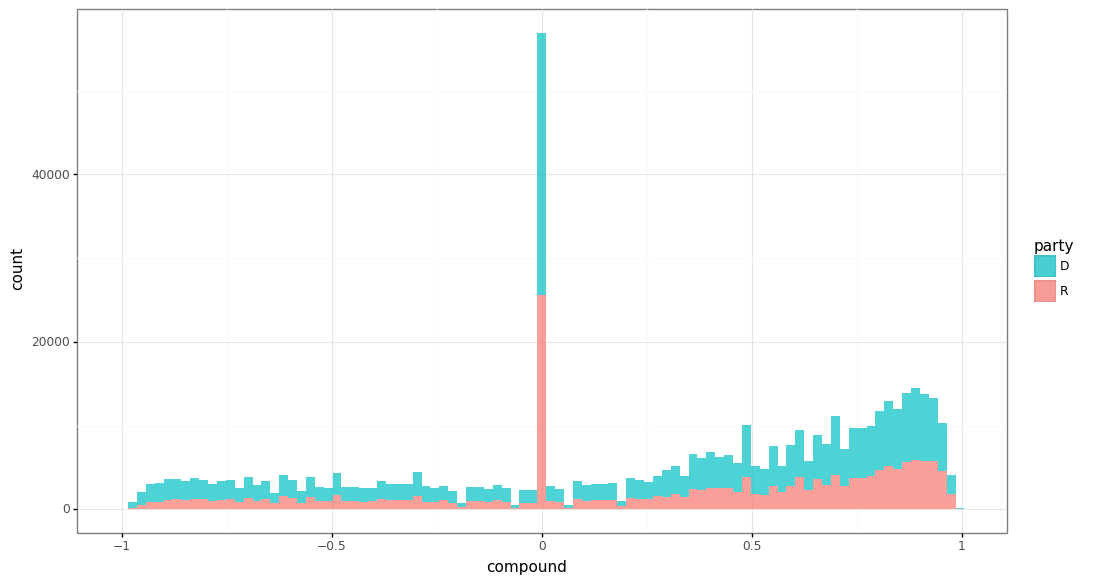

<ggplot: (8732218789569)>

In [41]:
p9.ggplot(
        all_tweets,
        p9.aes(x = "compound", fill = "party")) + \
    p9.geom_histogram(alpha = 0.7) + \
    p9.theme_bw() + \
    p9.scale_fill_manual(values = {"D": "#00BFC4", "R": "#F8766D"})